In [2]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve


In [3]:
#Loading dataset
df = pd.read_csv("processed_stroke_dataset.csv")

In [4]:
print("Initial shape:", df.shape)
print("Initial columns:", df.columns.tolist())

Initial shape: (15000, 51)
Initial columns: ['Age', 'Gender', 'Hypertension', 'Heart Disease', 'Average Glucose Level', 'Body Mass Index (BMI)', 'Stroke History', 'Family History of Stroke', 'Stress Levels', 'Diagnosis', 'Work Type_Government Job', 'Work Type_Never Worked', 'Work Type_Private', 'Work Type_Self-employed', 'Residence Type_Rural', 'Residence Type_Urban', 'Smoking Status_Currently Smokes', 'Smoking Status_Formerly Smoked', 'Smoking Status_Non-smoker', 'Alcohol Intake_Frequent Drinker', 'Alcohol Intake_Never', 'Alcohol Intake_Rarely', 'Alcohol Intake_Social Drinker', 'Physical Activity_High', 'Physical Activity_Low', 'Physical Activity_Moderate', 'Dietary Habits_Gluten-Free', 'Dietary Habits_Keto', 'Dietary Habits_Non-Vegetarian', 'Dietary Habits_Paleo', 'Dietary Habits_Pescatarian', 'Dietary Habits_Vegan', 'Dietary Habits_Vegetarian', 'Marital Status_Divorced', 'Marital Status_Married', 'Marital Status_Single', 'Systolic_BP', 'Diastolic_BP', 'HDL', 'LDL', 'Blurred Vision',

In [5]:
#Splitting Features and Target
X = df.drop(columns=["Diagnosis"])
y = df["Diagnosis"]

In [6]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [7]:
#Scaling
scaler_std = StandardScaler()
scaler_minmax = MinMaxScaler()

X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)

X_train_mm = scaler_minmax.fit_transform(X_train)
X_test_mm = scaler_minmax.transform(X_test)

In [8]:
#Evaluation Function
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    cm = confusion_matrix(y_test, y_pred)

    print(f"\nEvaluation for {model_name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if auc is not None:
        print(f"AUC: {auc:.4f}")

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f"{model_name} - ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.grid()
        plt.show()

Best Logistic Regression Params: {'C': 0.1, 'solver': 'saga'}

Evaluation for Logistic Regression
Accuracy: 0.5070
Precision: 0.5053
Recall: 0.4826
F1 Score: 0.4937
AUC: 0.5075


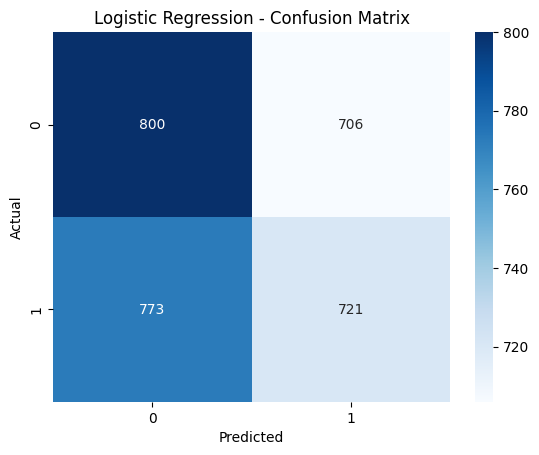

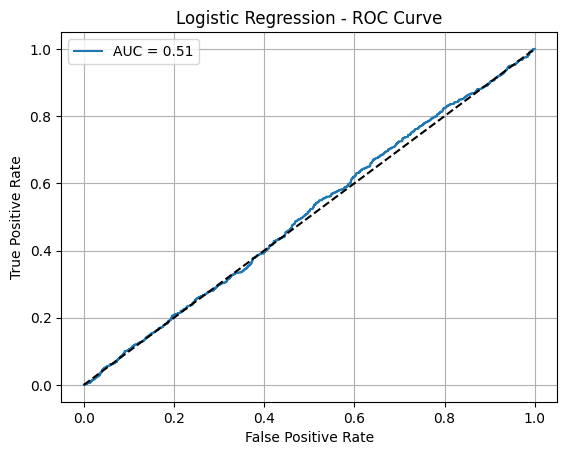

In [9]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5)
lr.fit(X_train_std, y_train)

print("Best Logistic Regression Params:", lr.best_params_)
evaluate_model(lr, X_test_std, y_test, model_name="Logistic Regression")


In [11]:
#Showing CV results table
cv_df = pd.DataFrame(lr.cv_results_)
keep = [c for c in cv_df.columns if c.startswith("param_")] + ["mean_test_score","std_test_score","rank_test_score"]
display(cv_df[keep].sort_values("rank_test_score").head(10))
best_lr = lr.best_estimator_

,param_C,param_solver,mean_test_score,std_test_score,rank_test_score
3,0.10,saga,0.495417,0.004370,1
2,0.10,liblinear,0.495333,0.004537,2
0,0.01,liblinear,0.495250,0.004002,3
4,1.00,liblinear,0.495250,0.004254,3
6,10.00,liblinear,0.495250,0.004254,3
5,1.00,saga,0.495250,0.004254,3
7,10.00,saga,0.495250,0.004254,3
1,0.01,saga,0.495167,0.003993,8


In [13]:
#Displays which features push the prediction up/down
coefs = best_lr.coef_.ravel()
names = getattr(X_train, "columns", np.arange(len(coefs)))
top = np.argsort(np.abs(coefs))[::-1][:12]
pd.DataFrame({"feature": np.array(names)[top], "coef": coefs[top]})

,feature,coef
0,HDL,-0.045847
1,Stress Levels,-0.037615
2,Average Glucose Level,0.033018
3,Family History of Stroke,-0.031382
4,Hypertension,-0.028132
5,Unknown,-0.021910
6,Marital Status_Married,0.020634
7,Body Mass Index (BMI),-0.019154
8,Dietary Habits_Paleo,0.018429
9,Stroke History,-0.017995


In [12]:
#Printing classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, best_lr.predict(X_test), digits=4))

              precision    recall  f1-score   support

           0     0.5017    0.9748    0.6625      1506
           1     0.4865    0.0241    0.0459      1494

    accuracy                         0.5013      3000
   macro avg     0.4941    0.4994    0.3542      3000
weighted avg     0.4941    0.5013    0.3554      3000



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
